# Machine Learning Project

## Predict traffic volume

Using the "Metro Interstate Traffic Volume" public dataset from the UCI repository (source: http://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume)

This data contains 48204 instances of hourly interstate 94 Westbound traffic volume for MN DoT ATR station 301, roughly midway between Minneapolis and St Paul, MN. Hourly weather features and holidays included for impacts on traffic volume. Attributes include:

   1. Holiday (holiday): Categorical US National holidays plus regional holiday, Minnesota State Fair (nominal)  
   2. Temperature (temp): Numeric Average in kelvin (numerical)
   3. Rain (rain_1h): Numeric Amount in mm of rain that occurred in the hour (numerical)
   4. Snow (snow_1h): Numeric Amount in mm of snow that occurred in the hour (numerical)
   5. Clouds (clouds_all): Numeric Percentage of cloud cover (numerical)
   6. Weather Main: weather_main Categorical Short textual description of the current weather (ordinal)
   7. Weather Description (weather_description): Categorical Longer textual description of the current weather (ordinal)
   8. Date & Time (date_time): DateTime Hour of the data collected in local CST time
   9. Traffic Volume (traffic_volume) Numeric Hourly I-94 ATR 301 reported westbound traffic volume

   
The Holiday attribute needs to be polished. In the dataset, only at 0:00:00 row of the holiday is labelled. Holiday should be effective through out the 24 rows, adjustment is required.

"Weather Main" and "Weather Description" are highly similar, it appears that the latter breaks the weather data into more specific classes, which I believe is more than sufficient in this usage, hence the column will be dropped.




## Scope of Project

Practice applying several different supervised machine learning techniques to this data set, and see which one yields the highest accuracy as measured with K-Fold cross validation (K=10). Apply:

* Decision tree
* Random forest
* KNN
* Naive Bayes
* SVM
* Logistic Regression
* a neural network using Keras.

## Data preparation

Start by importing the dataset file into a Pandas dataframe.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd

#Read data file
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
df.head(10)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
5,None,291.72,0.0,0.0,1,Clear,sky is clear,2012-10-02 14:00:00,5181
6,None,293.17,0.0,0.0,1,Clear,sky is clear,2012-10-02 15:00:00,5584
7,None,293.86,0.0,0.0,1,Clear,sky is clear,2012-10-02 16:00:00,6015
8,None,294.14,0.0,0.0,20,Clouds,few clouds,2012-10-02 17:00:00,5791
9,None,293.10,0.0,0.0,20,Clouds,few clouds,2012-10-02 18:00:00,4770


#### "Holiday" and "Date_time" column are not ready

Note that the data type of 'date_time' is a Pandas 'series' class, which is not ideal to work with.

In [2]:
print(type(df['date_time']))

<class 'pandas.core.series.Series'>


Let's expand the date_time string into timestamp format, and store the individual date and time components into the dateset.

While we loop through the data to do so, convert the holiday from string to index (integer).

The nominal references are stored in a dictionary (with unique entries).

In [3]:
import datetime

# Make a unique dictionary
holiday_dict = {}

# n is a counting variable to stores the last new index
n = 1
# holiday_idx is the actual index variable for a holiday, new or reoccurring
holiday_idx = 0

# Loop through the data and modify
print("----- Converting Holiday name strings to index integer... ---------- ")
for x,y in df.iterrows():
    # Convert string date_time into a timestamp data
    now = datetime.datetime.strptime(y['date_time'], '%Y-%m-%d %H:%M:%S')
    
    # append time data column to the dataframe
    df.at[x, 'year'] = now.year
    df.at[x, 'month'] = now.month
    df.at[x, 'day'] = now.day
    df.at[x, 'hour'] = now.hour
    
    # if this row has not been converted to index
    if(type(df.at[x,'holiday']) != int):
        # get the string
        holiday_str = y['holiday']
        
        # if this row is at mid-night
        if(now.hour == 0):
            # this row should decide for following rows, for the rest of the day
            # if today is not a hoilday
            if(holiday_str == 'None'):
                # index should be zero
                holiday_idx = 0 
            # otherwise if today is a holiday
            else:
                # do different things depending on whether this holiday 
                # is already in the dictionary or not
                # if this holiday is not in data yet
                if holiday_str not in holiday_dict.keys():
                    # add to the dictionary
                    holiday_dict[holiday_str] = n
                    # pass the new index value for later to assign
                    holiday_idx = n
                    # increase the last new index count
                    n += 1
                    
                # if this holiday is already in data    
                else:
                    holiday_idx = holiday_dict[holiday_str];
                
                # this is a convertion that just happened, print to confirm
                print(y['holiday'], "->", holiday_idx, " : ", y['date_time'])

        # Update the holiday column data with "today"'s holiday index
        # recall that holiday_idx by default is 0 ("None")
        # every mid-night from the loop above would update "today"'s holiday index
        df.at[x, 'holiday'] = np.float64(holiday_idx)
        
        

df['year'] = df['year'].astype(np.int64)
df['month'] = df['month'].astype(np.int64)
df['day'] = df['day'].astype(np.int64)
df['hour'] = df['hour'].astype(np.int64)
        
print("----- ... Done ----- ")

----- Converting Holiday name strings to index integer... ---------- 
Columbus Day -> 1  :  2012-10-08 00:00:00
Veterans Day -> 2  :  2012-11-12 00:00:00
Thanksgiving Day -> 3  :  2012-11-22 00:00:00
Christmas Day -> 4  :  2012-12-25 00:00:00
New Years Day -> 5  :  2013-01-01 00:00:00
Washingtons Birthday -> 6  :  2013-02-18 00:00:00
Memorial Day -> 7  :  2013-05-27 00:00:00
Independence Day -> 8  :  2013-07-04 00:00:00
State Fair -> 9  :  2013-08-22 00:00:00
Labor Day -> 10  :  2013-09-02 00:00:00
Columbus Day -> 1  :  2013-10-14 00:00:00
Veterans Day -> 2  :  2013-11-11 00:00:00
Thanksgiving Day -> 3  :  2013-11-28 00:00:00
Christmas Day -> 4  :  2013-12-25 00:00:00
New Years Day -> 5  :  2014-01-01 00:00:00
Martin Luther King Jr Day -> 11  :  2014-01-20 00:00:00
Washingtons Birthday -> 6  :  2014-02-17 00:00:00
Memorial Day -> 7  :  2014-05-26 00:00:00
Independence Day -> 8  :  2015-07-03 00:00:00
State Fair -> 9  :  2015-08-27 00:00:00
Labor Day -> 10  :  2015-09-07 00:00:00
Columb

Notice that some entries have duplicate date time. It is uncertain whether those rows are duplicate entries (with other columns having various data) or only the timestamp is incorrect. Some hours are missing, too. However, for now let's proceed without making any counter measure to those error.

Now apply the same index conversion to the "weather_main" column.

In [4]:
# Make a unique dictionary
weather_dict = {}

# n is a counting variable to stores the last new index
n = 1
# weather_idx is the actual index variable for a weather condition, new or reoccurring
weather_idx = 0

# Loop through the data and modify
print("----- Converting Weather strings to index integer... ---------- ")
for x,y in df.iterrows():
  
 
    # if this row has not been converted to index
    if(type(df.at[x,'weather_main']) != int):
        # get the string
        weather_str = y['weather_main']
        
      
        # if weather is clear
        if(weather_str == 'Clear'):
            # index should be zero
            weather_idx = 0 
        # otherwise 
        else:
            # do different things depending on whether this weather condition 
            # is already in the dictionary or not
            # if this weather condition is not in data yet
            if weather_str not in weather_dict.keys():
                # add to the dictionary
                weather_dict[weather_str] = n
                # pass the new index value for later to assign
                weather_idx = n
                # increase the last new index count
                n += 1
                # this is a new condition that was added to the record, print to confirm
                print(y['weather_main'], "->", weather_idx, " : ", y['date_time'])
                
            # if this weather is already in data    
            else:
                weather_idx = weather_dict[weather_str];

            

        # Update the weather column data with the current weather index
        # recall that weather_idx by default is 0 ("Clear")
        # every hour would update
        df.at[x, 'weather_main'] = np.float64(weather_idx)
        
        


print("----- ... Done ----- ")

----- Converting Weather strings to index integer... ---------- 
Clouds -> 1  :  2012-10-02 09:00:00
Rain -> 2  :  2012-10-09 15:00:00
Drizzle -> 3  :  2012-10-10 07:00:00
Mist -> 4  :  2012-10-14 08:00:00
Haze -> 5  :  2012-10-14 09:00:00
Fog -> 6  :  2012-10-14 23:00:00
Thunderstorm -> 7  :  2012-10-23 15:00:00
Snow -> 8  :  2012-10-26 09:00:00
Squall -> 9  :  2013-05-12 02:00:00
Smoke -> 10  :  2015-07-06 13:00:00
----- ... Done ----- 


Take a look at the brief summary of our data. 

In [5]:
df_des = df.describe()
print(df_des)

               temp       rain_1h       snow_1h    clouds_all  traffic_volume  \
count  48204.000000  48204.000000  48204.000000  48204.000000    48204.000000   
mean     281.205870      0.334264      0.000222     49.362231     3259.818355   
std       13.338232     44.789133      0.008168     39.015750     1986.860670   
min        0.000000      0.000000      0.000000      0.000000        0.000000   
25%      272.160000      0.000000      0.000000      1.000000     1193.000000   
50%      282.450000      0.000000      0.000000     64.000000     3380.000000   
75%      291.806000      0.000000      0.000000     90.000000     4933.000000   
max      310.070000   9831.300000      0.510000    100.000000     7280.000000   

               year         month           day          hour  
count  48204.000000  48204.000000  48204.000000  48204.000000  
mean    2015.512426      6.506037     15.737636     11.398162  
std        1.893211      3.400221      8.722938      6.940238  
min     2012.0

It appears that the count is equal for all columns, likely no missing data exist. But in the case where it does, the following code would drop all the rows with NaN.

In [6]:
# drop all NaN rows
df = df.dropna()

In the case of the dataset file containing other specific marking as null indicator, then use the following code to load the data again, where, in this example, converts all "?" cells to NaN.  

In [24]:
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv", na_values = "?", na_filter = True)

Next, there seems to be some errornous data to take care of.

Temperature for example, the first clue is that there a min value of "0". That is -273 in Celcius, or -456 in Fahrenheit, which does not sound reasonable. 

For a further investigation, we can check with the historgram plot.

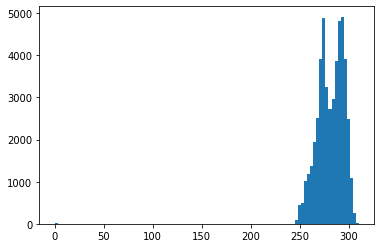

In [6]:
import matplotlib.pyplot as plt
col = df['temp']
plt.hist(df['temp'],100)
plt.show()

We can see better if the plot exclude a certain out-ranged data. The following is a code that generally works for excluding outliers for plotting:

In [7]:
# Take in data column and returns out that filters out +/- 4 deviation (unless give specific upper and lower bound)
def reject_outliers(data_col, lower_bound = 0, upper_bound = 0):
    u = np.nanmedian(data_col)
    s = np.std(data_col)
    if not lower_bound:
        lower_bound = u - 4 * s     
    if not upper_bound:
        upper_bound = u + 4 * s
        
    filtered = [e for e in data_col if (lower_bound < e < upper_bound)]
    
    return filtered

Let's check the plot again...

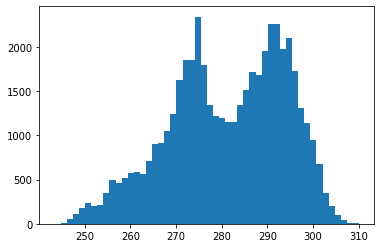

In [8]:
filtered_col = reject_outliers(col)

plt.hist(filtered_col, 50)
plt.show()

Here we clearly see the outlier entry has been skewing the dataset. Such data should be excluded. 

Before we apply modification to the temperature column, let's also check other numeric data for outliers.

Rain has an unsual max value, so let's take a close look.

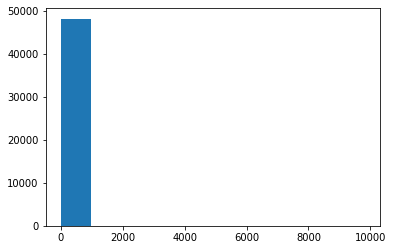

In [9]:
col = df['rain_1h']
plt.hist(col,10)
plt.show()

Sure enough, there is some strong outlier stretching mean. 

9000 mm per hour is unrealistic. Extreme weather in the U.S can possibly go up to 1800 per hour (https://www.cnn.com/travel/article/extreme-weather-records/index.html), but according to Wikipedia, a "Violent Rain" is ">50 mm per hour" (https://en.wikipedia.org/wiki/Rain). In our dataset, other 2nd greatest rain in record is 55 mm.

With the outlier data pulling up the standard deviation of the column, we cannot simply rely on the filtering function's standard filtering (because std = 44).   

We can constrain with a reasonable range of 0.00 to 60.00.

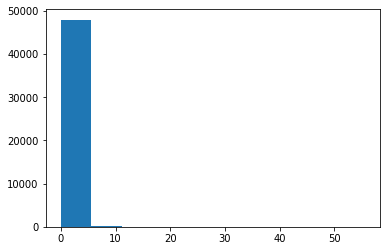

In [10]:
filtered_col = reject_outliers(col,0,60)

plt.hist(filtered_col,10)
plt.show()

Cannot see the data clearly, since the majority of data are clustered between 0 to 5. However, the errorouns data is certainly discarded here.

Although rain and snow columns still have rare and extreme cases being the "outlier", these data are meaningful. Traffic volume may response significantly to these rare cases. If this ML product is to be developed into an anomaly detection, these outlier data should be evaluated (assuming this does not cause problem to the learning models).

Other numeric columns seems fine. Now we actually remove those rows from the dataset.

In [11]:
df = df.drop(df[(df.temp < 220)].index)
df = df.drop(df[df.rain_1h > 60].index)

In [12]:
df_des = df.describe()
print(df_des)

               temp       rain_1h       snow_1h    clouds_all  traffic_volume  \
count  48193.000000  48193.000000  48193.000000  48193.000000    48193.000000   
mean     281.263786      0.130342      0.000222     49.371942     3260.174029   
std       12.709364      1.003480      0.008169     39.013548     1986.754010   
min      243.390000      0.000000      0.000000      0.000000        0.000000   
25%      272.180000      0.000000      0.000000      1.000000     1194.000000   
50%      282.460000      0.000000      0.000000     64.000000     3380.000000   
75%      291.810000      0.000000      0.000000     90.000000     4933.000000   
max      310.070000     55.630000      0.510000    100.000000     7280.000000   

               year         month           day          hour  
count  48193.000000  48193.000000  48193.000000  48193.000000  
mean    2015.512730      6.507045     15.738178     11.399353  
std        1.893301      3.399867      8.721451      6.940353  
min     2012.0

The data seems cleaned up now. Moving on...


## Data Analysis / Discussion

We have no clear idea how the features are influencing the traffic volume. 

Seaborn allows us to visualize data to understand what we're dealing with. 

For example, take a look at the relationship between temperature and traffic volume data.

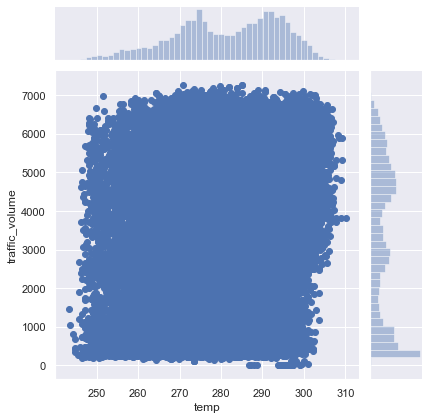

In [13]:
import seaborn as sns
sns.set()
sns.jointplot(x="temp", y="traffic_volume", data=df)

This does not seem useful at all. The data are rather evenly distributed. Does this imply that no matter how hot or cold the temperature is, that the traffic may vary between 0 to 7800 without bias? From real life observation, the answer is intuitively "No". So is there something wrong with the dataset?

Now take a look at the relationship bewteen hour and traffic.

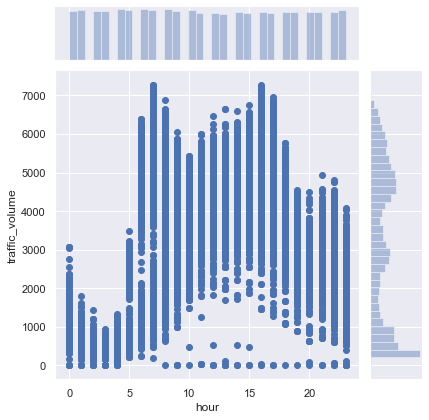

In [14]:
sns.set()
sns.jointplot(x="hour", y="traffic_volume", data=df)

What we see here is a general pattern that there are quiet hours and busy hours. 

Ofcourse, there are data showing that the hottest and the coldest days, there are late night hour blocks where traffic is very low, and also busy hours in the day. 

What if we only compare data from at 9:00 am rush hour?

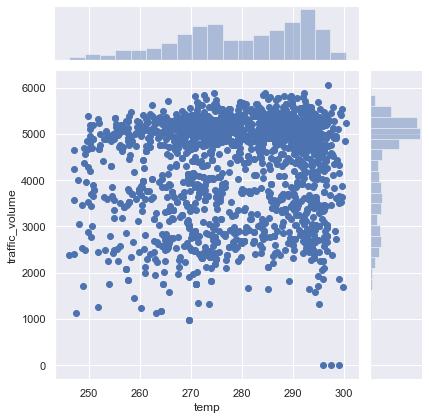

In [15]:
df2 = df.where(df['hour'] == 9)
sns.set()
sns.jointplot(x="temp", y="traffic_volume", data=df2)

Here we start to see some pattern, making the data meaningful.

Note that this pattern reflects only at the 9 to 10 am block. We do not know and should not assume that all the other hour blocks have the same human behavior tendency towards temperature. 

Some of the other features are also only meaningful when comparing hour-to-hour. But how should we plug the hour factor into the dataset in order for the machine to learn properly? I have a few abstracts in mind, but I do not have the experience to tackle that problem. Hence, I will move on disregarding it. (Will come back to that in future)

## Classification Problem

Traffic volume is currently an integer value ranging from 0 to 7280. We do not need the machine to predict the exact traffic volume quantity, we just need to know if its clear, light, moderate, or heavy.  Hence, let's break down the traffic volume into 4 classes. The method I choose to classify is a simple method (dividing by 2000), but there are many other ways to classify the grades of traffic weight. 

In [16]:
# Convert traffic volume into category 0, 1, 2, 3
df['traffic_volume'] = np.divide(df['traffic_volume'], 2000)
df['traffic_volume'] = df['traffic_volume'].astype('int64')
print ("Done!")

Done!


## Features and Targets data

After cleaning up the rows, we can select only the columns that we do need as our feature set.

Split the dataset into two, one is for the learning features (input), one is for the target variables (prediction outcome).

In [17]:
# A list of features (columns) from the dataset
feature_list = ['holiday','temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'hour']
#feature_list = ['hour']

# The ML will learn that these factors...
features = df[feature_list].values
print ('Features:\n', feature_list)
print (features[:10])

# ... cause these outcomes
targets = df['traffic_volume'].values 
print ('\nTargets:\n[traffic_volume]',)
print (targets[:10])

Features:
 ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'hour']
[[0.0 288.28 0.0 0.0 40 1.0 9]
 [0.0 289.36 0.0 0.0 75 1.0 10]
 [0.0 289.58 0.0 0.0 90 1.0 11]
 [0.0 290.13 0.0 0.0 90 1.0 12]
 [0.0 291.14 0.0 0.0 75 1.0 13]
 [0.0 291.72 0.0 0.0 1 0.0 14]
 [0.0 293.17 0.0 0.0 1 0.0 15]
 [0.0 293.86 0.0 0.0 1 0.0 16]
 [0.0 294.14 0.0 0.0 20 1.0 17]
 [0.0 293.1 0.0 0.0 20 1.0 18]]

Targets:
[traffic_volume]
[2 2 2 2 2 2 2 3 2 2]


# Training Models

Some of the models require the input data to be normalized. We will now normalize the attribute data, using preprocessing.StandardScaler().

In [18]:
from sklearn.preprocessing import StandardScaler

# Scale the model with StandardScaler
scaler = StandardScaler()

# Check results
scaled_features = scaler.fit_transform(features)
print ('Features:\n', feature_list)
print(scaled_features[:10])

Features:
 ['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'hour']
[[-0.15913356  0.55205645 -0.12989104 -0.02723145 -0.24022525 -0.45678703
  -0.34571406]
 [-0.15913356  0.63703405 -0.12989104 -0.02723145  0.65690832 -0.45678703
  -0.20162767]
 [-0.15913356  0.6543443  -0.12989104 -0.02723145  1.04139413 -0.45678703
  -0.05754128]
 [-0.15913356  0.69761993 -0.12989104 -0.02723145  1.04139413 -0.45678703
   0.08654512]
 [-0.15913356  0.77708972 -0.12989104 -0.02723145  0.65690832 -0.45678703
   0.23063151]
 [-0.15913356  0.82272583 -0.12989104 -0.02723145 -1.23988837 -0.89417899
   0.37471791]
 [-0.15913356  0.93681613 -0.12989104 -0.02723145 -1.23988837 -0.89417899
   0.5188043 ]
 [-0.15913356  0.99110737 -0.12989104 -0.02723145 -1.23988837 -0.89417899
   0.66289069]
 [-0.15913356  1.0131386  -0.12989104 -0.02723145 -0.752873   -0.45678703
   0.80697709]
 [-0.15913356  0.93130832 -0.12989104 -0.02723145 -0.752873   -0.45678703
   0.95106348]]


## Split up Training and Testing data

Before moving to K-Fold cross validation and random forests, start by creating a single train/test split of our data. Set aside 75% for training, and 25% for testing.

In [19]:
import numpy
from sklearn.model_selection import train_test_split

numpy.random.seed(54321)

X_train, X_test, y_train, y_test = train_test_split(scaled_features, targets, train_size=0.75, random_state=77777)

Now it is ready to fit the training data into various models.

In [20]:
# Scoreboard to keep track of each model's score
score_dict = {}

## Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train,y_train)

score_dict['Tree Decision Classifier'] = clf.score(X_test, y_test)
print (score_dict['Tree Decision Classifier'])

0.7713503195285916


Now instead of a single train/test split, use K-Fold cross validation to get a better measure of your model's accuracy (K=30). 

In [22]:
from sklearn.model_selection import cross_val_score
# We give cross_val_score a model, the entire data set and its "real" values, and the number of folds:
scores = cross_val_score(clf, X_test, y_test, cv=30)

# Print the accuracy for each fold:
print(scores)

# And the mean accuracy of all 30 folds:
print(scores.mean())

score_dict['K-Fold Cross Validation'] = scores.mean()

[0.74689826 0.77915633 0.74937965 0.7369727  0.75434243 0.70471464
 0.69727047 0.73449132 0.7146402  0.75682382 0.74689826 0.74193548
 0.7617866  0.72952854 0.73945409 0.75124378 0.75621891 0.78054863
 0.74314214 0.72319202 0.7755611  0.735      0.73       0.7375
 0.75       0.75       0.73433584 0.78195489 0.71929825 0.73684211]
0.7433043486168647


## Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

clf2 = RandomForestClassifier(n_estimators=30)
clf2 = clf2.fit(X_train,y_train)

scores2 = cross_val_score(clf2, X_test, y_test, cv=30)

# Print the accuracy for each fold:
print('Accuracy for each fold:')
print(scores2)

# And the mean accuracy of all 30 folds:
print('\nThe mean accuracy of all 30 folds')
print(scores2.mean())

score_dict['Random Forest Classifier'] = scores2.mean()

Accuracy for each fold:
[0.79156328 0.76426799 0.75682382 0.76674938 0.78411911 0.72456576
 0.71712159 0.74193548 0.73449132 0.77419355 0.76923077 0.74441687
 0.78411911 0.75930521 0.75186104 0.75124378 0.77860697 0.78054863
 0.74314214 0.72069825 0.7755611  0.765      0.7475     0.7425
 0.765      0.735      0.73433584 0.78446115 0.75689223 0.76190476]

The mean accuracy of all 30 folds
0.7569053041303139


## SVM
svm.SVC with a linear kernel

In [24]:
from sklearn import svm

C = 1.0
svc = svm.SVC(kernel='linear', C=C)

cv_scores = cross_val_score(svc, X_train, y_train, cv=10)

print(cv_scores)

score_dict['SVM.SVC'] = cv_scores.mean()

[0.68196903 0.68141593 0.68832965 0.67643805 0.68298755 0.67985612
 0.6900083  0.6900083  0.67755328 0.67829457]


In [25]:
print (cv_scores.mean())

0.6826860782006697


## KNN
K-Nearest-Neighbors

In [26]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)

print(neigh.score(X_test, y_test))

0.7693584529836501


Choosing K is tricky, so we can't discard KNN until we've tried different values of K. Here's a for loop to run KNN with K values ranging from 1 to 50 and see if K makes a substantial difference. 

In [27]:
max_score = 0
best_K = 1
for K in range(1,51):
    neigh = KNeighborsClassifier(n_neighbors=K)
    neigh.fit(X_train, y_train)    
    score = neigh.score(X_test, y_test)
    if (score > max_score):
        max_score = score
        best_K = K

print("Best outcome: K=", best_K, ": ", max_score)
score_dict['K-Nearest-Neighbors'] = max_score

Best outcome: K= 11 :  0.7696904307411403


## Naive Bayes

Now try naive_bayes.MultinomialNB.

In [28]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)


from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()

classifier.fit(scaled_X_train, y_train)

print(classifier.score(scaled_X_test, y_test))

score_dict['Naive Bayes'] = classifier.score(scaled_X_test, y_test)


0.42667441281434143


## Revisiting SVM

svm.SVC may perform differently with different kernels. Try the rbf and poly kernels and see what the best-performing kernel is.

In [29]:
svc = svm.SVC(C=1.0, decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf', max_iter=-1, probability=False, random_state=None, 
tol=0.001, verbose=False).fit(scaled_X_train, y_train)

print(svc.score(scaled_X_test, y_test))

score_dict['SVM with RBF kernel'] = svc.score(scaled_X_test, y_test)

0.7401444103245083


In [30]:
svc = svm.SVC(C=1.0, decision_function_shape='ovo', degree=3, gamma='scale', kernel='poly', max_iter=-1, probability=False, random_state=None, 
tol=0.001, verbose=False).fit(scaled_X_train, y_train)

print(svc.score(scaled_X_test, y_test))
score_dict['SVM with Poly kernel'] = svc.score(scaled_X_test, y_test)

0.6544941488920243


## Logistic Regression

We've tried all these fancy techniques, but fundamentally this is just a binary classification problem. Try Logisitic Regression, which is a simple way to tackling this sort of thing.

In [31]:
from sklearn.linear_model import LogisticRegression
logistic_clf = LogisticRegression(penalty = 'l2', dual=False, C=1.0, fit_intercept=False, intercept_scaling=1, random_state=None, solver='lbfgs', max_iter=1000, multi_class='multinomial', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None).fit(scaled_X_train, y_train)
print(logistic_clf.score(scaled_X_test, y_test))    

score_dict['Logistic Regression'] = logistic_clf.score(scaled_X_test, y_test)

0.5998838077848784


## Neural Networks
Using Keras to set up a neural network

Start with importing modules.

In [32]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop

Setting up session, configuring GPU.

In [33]:
import tensorflow as tf
from tensorflow.keras.backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

Setting the model's layers.

In [34]:
model = Sequential()
model.add(Dense(7, activation='relu', input_shape=(7,)))
model.add(Dense(7, activation='relu'))
model.add(Dense(4, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 56        
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 32        
Total params: 144
Trainable params: 144
Non-trainable params: 0
_________________________________________________________________


Here we go.

In [36]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [37]:
history = model.fit(scaled_X_train, y_train,
                    batch_size=10,
                    epochs=50,
                    verbose=2,
                    validation_data=(scaled_X_test, y_test))

Train on 36144 samples, validate on 12049 samples
Epoch 1/50
 - 8s - loss: 0.9511 - acc: 0.6427 - val_loss: 0.7685 - val_acc: 0.6859
Epoch 2/50
 - 8s - loss: 0.7246 - acc: 0.7084 - val_loss: 0.6936 - val_acc: 0.7231
Epoch 3/50
 - 8s - loss: 0.6811 - acc: 0.7231 - val_loss: 0.6566 - val_acc: 0.7276
Epoch 4/50
 - 8s - loss: 0.6518 - acc: 0.7364 - val_loss: 0.6329 - val_acc: 0.7427
Epoch 5/50
 - 8s - loss: 0.6338 - acc: 0.7424 - val_loss: 0.6276 - val_acc: 0.7429
Epoch 6/50
 - 8s - loss: 0.6247 - acc: 0.7426 - val_loss: 0.6154 - val_acc: 0.7450
Epoch 7/50
 - 8s - loss: 0.6184 - acc: 0.7426 - val_loss: 0.6103 - val_acc: 0.7517
Epoch 8/50
 - 8s - loss: 0.6141 - acc: 0.7415 - val_loss: 0.6065 - val_acc: 0.7199
Epoch 9/50
 - 8s - loss: 0.6102 - acc: 0.7422 - val_loss: 0.6048 - val_acc: 0.7255
Epoch 10/50
 - 8s - loss: 0.6074 - acc: 0.7427 - val_loss: 0.5998 - val_acc: 0.7307
Epoch 11/50
 - 8s - loss: 0.6038 - acc: 0.7426 - val_loss: 0.5981 - val_acc: 0.7426
Epoch 12/50
 - 8s - loss: 0.6013 - 

In [40]:
history = model.fit(scaled_X_train, y_train,
                    batch_size=10,
                    epochs=50,
                    verbose=2,
                    validation_data=(scaled_X_test, y_test))

Train on 36144 samples, validate on 12049 samples
Epoch 1/50
 - 8s - loss: 0.5322 - acc: 0.7682 - val_loss: 0.5333 - val_acc: 0.7660
Epoch 2/50
 - 7s - loss: 0.5291 - acc: 0.7697 - val_loss: 0.5365 - val_acc: 0.7674
Epoch 3/50
 - 7s - loss: 0.5293 - acc: 0.7709 - val_loss: 0.5352 - val_acc: 0.7665
Epoch 4/50
 - 7s - loss: 0.5282 - acc: 0.7703 - val_loss: 0.5394 - val_acc: 0.7645
Epoch 5/50
 - 7s - loss: 0.5283 - acc: 0.7708 - val_loss: 0.5381 - val_acc: 0.7719
Epoch 6/50
 - 7s - loss: 0.5274 - acc: 0.7709 - val_loss: 0.5384 - val_acc: 0.7667
Epoch 7/50
 - 7s - loss: 0.5266 - acc: 0.7716 - val_loss: 0.5367 - val_acc: 0.7671
Epoch 8/50
 - 7s - loss: 0.5281 - acc: 0.7711 - val_loss: 0.5310 - val_acc: 0.7681
Epoch 9/50
 - 7s - loss: 0.5261 - acc: 0.7721 - val_loss: 0.5300 - val_acc: 0.7681
Epoch 10/50
 - 7s - loss: 0.5253 - acc: 0.7730 - val_loss: 0.5337 - val_acc: 0.7763
Epoch 11/50
 - 7s - loss: 0.5260 - acc: 0.7729 - val_loss: 0.5337 - val_acc: 0.7658
Epoch 12/50
 - 7s - loss: 0.5256 - 

In [42]:
# evaluate the keras model
_, accuracy = model.evaluate(scaled_X_test, y_test, verbose=0)

print(accuracy)
score_dict['Keras NN'] = accuracy

0.76919246


# Results

These are the results from the various models. 

In [43]:
for x in score_dict:
    print (x, " : ", round((score_dict[x] * 100),2), "%")

Tree Decision Classifier  :  77.14 %
K-Fold Cross Validation  :  74.33 %
Random Forest Classifier  :  75.69 %
SVM.SVC  :  68.27 %
K-Nearest-Neighbors  :  76.97 %
Naive Bayes  :  42.67 %
SVM with RBF kernel  :  74.01 %
SVM with Poly kernel  :  65.45 %
Logistic Regression  :  59.99 %
Keras NN  :  76.92 %


### Final Remark

This is my first time building an ML project using a "raw" dataset. 
As mentioned above, there are a few concerns with the way I am using the dataset. It could be instead:

1) an hour-to-hour comparison to learn the influence of weather, holiday, and temperature on traffic.

2) predicting the next hour's traffic going up or down

3) put weekday / weekend as a feature

Being new to this field, I can only do so much for now. I might come back to it later.